In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [14]:
sns.get_dataset_names()

['anagrams',
 'anscombe',
 'attention',
 'brain_networks',
 'car_crashes',
 'diamonds',
 'dots',
 'dowjones',
 'exercise',
 'flights',
 'fmri',
 'geyser',
 'glue',
 'healthexp',
 'iris',
 'mpg',
 'penguins',
 'planets',
 'seaice',
 'taxis',
 'tips',
 'titanic']

In [15]:
sns.load_dataset('planets')

df = sns.load_dataset('planets')

# 'method' = Discovery Method; How the Planet was Discovered
# 'number' = Number of Planets Discovered
# 'distance' = Distance of Planet(s) from Earth (in Light Years)

In [16]:
df.head(4)

,method,number,orbital_period,mass,distance,year
0,Radial Velocity,1,269.300,7.10,77.40,2006
1,Radial Velocity,1,874.774,2.21,56.95,2008
2,Radial Velocity,1,763.000,2.60,19.84,2011
3,Radial Velocity,1,326.030,19.40,110.62,2007


In [17]:
df['mass'].fillna(df['mass'].mean(), inplace = True)
df['distance'].fillna(df['distance'].mean(), inplace = True)

df.isnull().sum()

,0
method,0
number,0
orbital_period,43
mass,0
distance,0
year,0


In [18]:
# Binning Planet Masses

df['weight_class'] = pd.cut(df['mass'], bins = [0.0035, 2.21, 2.64, df['mass'].max()],
                            labels = ['lightweight', 'midweight', 'heavyweight'])
df['dist_class'] = pd.cut(df['distance'], bins = [1.34, 47, 265, 8501], labels = ['closeby', 'mid distance', 'far'])

In [19]:
df[df['weight_class'].isin(['lightweight', 'heavyweight'])]

,method,number,orbital_period,mass,distance,year,weight_class,dist_class
0,Radial Velocity,1,269.300,7.100,77.400000,2006,heavyweight,mid distance
1,Radial Velocity,1,874.774,2.210,56.950000,2008,lightweight,mid distance
3,Radial Velocity,1,326.030,19.400,110.620000,2007,heavyweight,mid distance
4,Radial Velocity,1,516.220,10.500,119.470000,2009,heavyweight,mid distance
5,Radial Velocity,1,185.840,4.800,76.390000,2008,heavyweight,mid distance
...,...,...,...,...,...,...,...,...
784,Radial Velocity,3,580.000,0.947,135.000000,2012,lightweight,mid distance
913,Radial Velocity,1,677.800,19.800,264.069282,2007,heavyweight,mid distance
914,Radial Velocity,1,6.958,0.340,264.069282,2014,lightweight,mid distance
915,Radial Velocity,1,5.118,0.400,264.069282,2014,lightweight,mid distance


In [20]:
disc_meth = [i for i in df['method'].unique()]
disc_meth

['Radial Velocity',
 'Imaging',
 'Eclipse Timing Variations',
 'Transit',
 'Astrometry',
 'Transit Timing Variations',
 'Orbital Brightness Modulation',
 'Microlensing',
 'Pulsar Timing',
 'Pulsation Timing Variations']

In [21]:
X = df[['number', 'orbital_period', 'weight_class', 'dist_class']]
y = df['method']

In [22]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

In [23]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

# Create a ColumnTransformer to apply OneHotEncoder to Categorical Features ONLY and keep Numericals as-is
preprocessor = ColumnTransformer(transformers = [('cat', OneHotEncoder(handle_unknown = 'ignore',
          sparse_output = False), ['weight_class', 'dist_class'])], # Encode these Categorical Columns
          remainder = 'passthrough') # Keep Numerical columns as they are

# Apply the ColumnTransformer to the Training and Test data
X_train_encoded = preprocessor.fit_transform(X_train)
X_test_encoded = preprocessor.transform(X_test)

In [24]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators = 100, random_state = 42)

rf_model = rf.fit(X_train_encoded, y_train)
y_pred = rf.predict(X_train_encoded)

In [25]:
# Probability of a Planet's Method of Discovery Being any of the Choices
train_probs = rf_model.predict_proba(X_train_encoded)

In [26]:
# Model Evaluation

from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix

print(f"\n Accuracy Score of the Random Forests Model: {round(accuracy_score(y_train, y_pred)*100, 2)}%")
print(f"\n ROC-AUC Score of the Random Forests Model: {round(roc_auc_score(y_train, train_probs, multi_class = 'ovr')*100, 2)}%")
print(f"\n Classification Report of the Random Forests Model: \n\n{classification_report(y_train, y_pred)}")
print(f"\n Confusion Matrix of the Random Forests Model: \n\n{confusion_matrix(y_train, y_pred)}")

# Looks Good to Proceed with!


 Accuracy Score of the Random Forests Model: 99.48%

 ROC-AUC Score of the Random Forests Model: 99.96%

 Classification Report of the Random Forests Model: 

                               precision    recall  f1-score   support

                   Astrometry       1.00      1.00      1.00         1
    Eclipse Timing Variations       1.00      1.00      1.00         7
                      Imaging       0.88      1.00      0.94        29
                 Microlensing       1.00      0.76      0.87        17
Orbital Brightness Modulation       1.00      1.00      1.00         1
                Pulsar Timing       1.00      1.00      1.00         4
  Pulsation Timing Variations       1.00      1.00      1.00         1
              Radial Velocity       1.00      1.00      1.00       402
                      Transit       1.00      1.00      1.00       310
    Transit Timing Variations       1.00      1.00      1.00         4

                     accuracy                           0

In [27]:
# A Copy of the fully selected Predictors' DataFrame
X_all = X.copy()
X_all = preprocessor.transform(X_all)

# Predicting Probabilities for the Entire Dataset
all_pr = rf_model.predict_proba(X_all)*100

# Column Names for Each Discovery Method Chance
pr_cols = [f"Chance of Discovery by Method of '{disc_meth}' (%)" for disc_meth in rf_model.classes_]

# Creating a DataFrame from "all_pr" with Columns and Identical Index as "df"
all_pr_df = pd.DataFrame(all_pr, columns = pr_cols, index = df.index)

# Concatenating this Probability DataFrame with the Original
df = pd.concat([df, all_pr_df], axis = 1)

# Let's See now!
pd.set_option('display.max_columns', None)
df.head(8)

,method,number,orbital_period,mass,distance,year,weight_class,dist_class,Chance of Discovery by Method of 'Astrometry' (%),Chance of Discovery by Method of 'Eclipse Timing Variations' (%),Chance of Discovery by Method of 'Imaging' (%),Chance of Discovery by Method of 'Microlensing' (%),Chance of Discovery by Method of 'Orbital Brightness Modulation' (%),Chance of Discovery by Method of 'Pulsar Timing' (%),Chance of Discovery by Method of 'Pulsation Timing Variations' (%),Chance of Discovery by Method of 'Radial Velocity' (%),Chance of Discovery by Method of 'Transit' (%),Chance of Discovery by Method of 'Transit Timing Variations' (%)
0,Radial Velocity,1,269.300,7.100000,77.40,2006,heavyweight,mid distance,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0
1,Radial Velocity,1,874.774,2.210000,56.95,2008,lightweight,mid distance,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0
2,Radial Velocity,1,763.000,2.600000,19.84,2011,midweight,closeby,3.0,0.0,0.0,0.0,0.0,0.0,0.0,97.0,0.0,0.0
3,Radial Velocity,1,326.030,19.400000,110.62,2007,heavyweight,mid distance,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0
4,Radial Velocity,1,516.220,10.500000,119.47,2009,heavyweight,mid distance,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0
5,Radial Velocity,1,185.840,4.800000,76.39,2008,heavyweight,mid distance,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0
6,Radial Velocity,1,1773.400,4.640000,18.15,2002,heavyweight,closeby,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0
7,Radial Velocity,1,798.500,2.638161,21.41,1996,midweight,closeby,4.0,0.0,0.0,0.0,0.0,0.0,0.0,96.0,0.0,0.0


## Logistic Regression (without L1/L2 Regularization)

<Axes: >

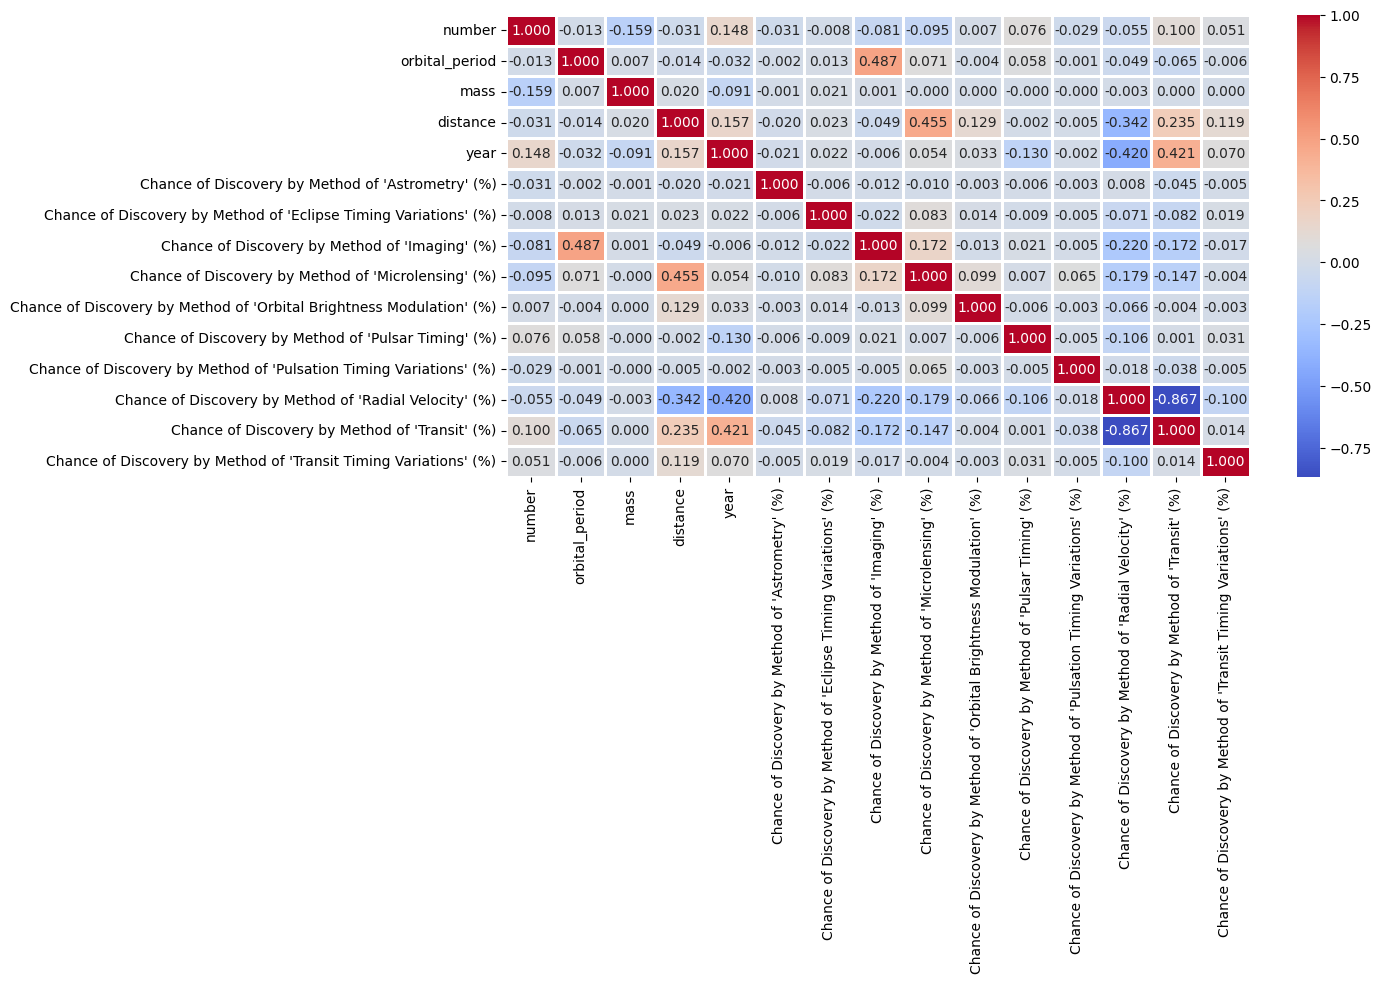

In [28]:
plt.figure(figsize = (12, 6))
sns.heatmap(df.corr(numeric_only = True), annot = True, cmap = 'coolwarm', fmt = ".3f", linewidth = 2)

# Microlensing seems to be the best Method to Discover Planets based on Increasing Distance from Earth

In [29]:
df.isnull().sum()

,0
method,0
number,0
orbital_period,43
mass,0
distance,0
year,0
weight_class,0
dist_class,0
Chance of Discovery by Method of 'Astrometry' (%),0
Chance of Discovery by Method of 'Eclipse Timing Variations' (%),0


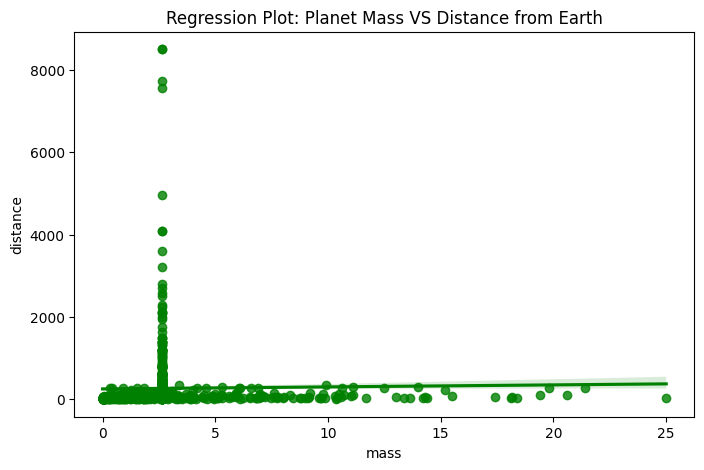

In [43]:
plt.figure(figsize = (8, 5))
sns.regplot(x = df['mass'], y = df['distance'], color = 'green')
plt.title("Regression Plot: Planet Mass VS Distance from Earth")
plt.show()

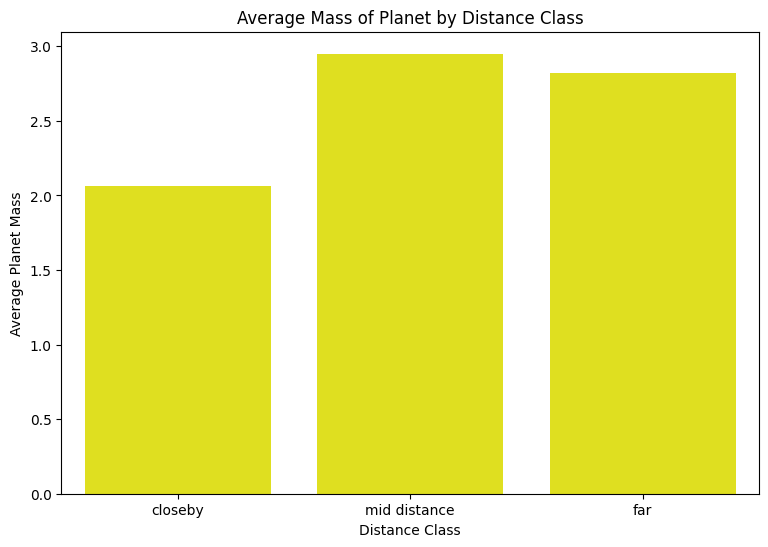

In [52]:
# Bar Chart
g1 = df.groupby('dist_class')['mass'].mean().round(2)

plt.figure(figsize = (9, 6))
sns.barplot(x = g1.index, y = g1.values, color = 'yellow')
plt.title("Average Mass of Planet by Distance Class")
plt.xlabel("Distance Class")
plt.ylabel("Average Planet Mass")
plt.show()

In [30]:
# Using Features that the Random Forests was Trained on, for Proper Context, and then 'Distance' too
df2 = df.loc[~df[['distance', 'number', 'orbital_period', 'weight_class', 'dist_class', 'method']].isnull().any(axis = 1)]

X2 = df2[['distance', 'number', 'orbital_period', 'weight_class', 'dist_class']]
y2 = df2['method']

In [31]:
y2_enc = y2.astype('category').cat.codes

In [32]:
from sklearn.linear_model import LogisticRegression

X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2_enc, test_size = 0.25, random_state = 7)

X_train_encoded2 = preprocessor.fit_transform(X_train2)
X_test_encoded2 = preprocessor.transform(X_test2)

In [33]:
from sklearn.linear_model import LogisticRegression

X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2_enc, test_size = 0.25, random_state = 7)
# 'stratify = y2_enc' ensures both y_train2 and y_test2 contain a representative distribution of all classes from "y2_enc"

logr = LogisticRegression()

logr.fit(X_train_encoded2, y_train2)
y_pred_logr = logr.predict(X_test_encoded2)

# Model Evaluation
print("\nAccuracy Score of the Logistic Regression Model: ", round(accuracy_score(y_test2, y_pred_logr)*100, 2), "%")


Accuracy Score of the Logistic Regression Model:  88.31 %


In [34]:
X_all = df.copy()

# Creating a Temporary DataFrame to Better Understand the Probabilities of the Distance Prediction being Done by each Method
preds_df = pd.DataFrame(((logr.predict_proba(X_test_encoded2)/logr.predict_proba(X_test_encoded2).sum())*100).round(3),
columns = logr.classes_, index = X_test2.index)

X_all = X_all.join(preds_df)

#df3 = pd.concat([X_all, preds_df], axis = 1)
#df3.head(7) # 3 = Microlensing, 6 = Radial Velocity

In [35]:
X_all[['dist_class', 0, 1, 2, 3, 4, 5, 6, 7, 8]].tail(8)

,dist_class,0,1,2,3,4,5,6,7,8
1027,closeby,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1028,far,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1029,closeby,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1030,mid distance,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1031,mid distance,0.0,0.002,0.0,0.003,0.042,0.0,0.0,0.035,0.267
1032,mid distance,0.0,0.001,0.0,0.001,0.034,0.0,0.0,0.027,0.295
1033,far,0.0,0.000,0.0,0.000,0.010,0.0,0.0,0.006,0.370
1034,mid distance,0.0,0.000,0.0,0.000,0.015,0.0,0.0,0.010,0.357


In [36]:
# Sample Prediction
X_all.groupby('dist_class')[[0, 1, 2, 3, 4, 5, 6, 7, 8]].mean().round(4)

,0,1,2,3,4,5,6,7,8
dist_class,,,,,,,,,
closeby,0.0112,0.0607,0.0340,0.0486,0.0103,0.0341,0.0152,0.1477,0.0290
mid distance,0.0001,0.0148,0.0033,0.0103,0.0119,0.0017,0.0004,0.1277,0.2160
far,0.0000,0.0000,0.0000,0.0000,0.0024,0.0000,0.0000,0.0038,0.3927
